## Merge the rental and repair-replace PR predictions



In [1]:
# Basic libraries
import geopandas as gpd
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

In [2]:
# Options
pd.set_option('display.max_columns', None)

### Load the repairReplacement and rental PR predictions

In [3]:
repairReplacementPredictions = pd.read_csv("./repair-replace/predictions/FEMA-Large-PR-predictions.csv")
print('There are {} predictions in the PR repair-replacement pipeline.'.format(len(repairReplacementPredictions)))

/Users/nitinserro/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 1041745 predictions in the PR repair-replacement pipeline.


In [4]:
repairReplacementPredictions.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'homeOwnersInsurance', 'floodInsurance', 'inspected', 'rpfvl',
       'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
       'foundationDamage', 'foundationDamageAmount', 'roofDamage',
       'roofDamageAmount', 'tsaEligible', 'tsaCheckedIn',
       'rentalAssistanceEligible', 'rentalAssistanceAmount',
       'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id', 'censusTractId', 'censusid',
       'tractid', 'tractname', 'county', 'state', 'haAmount',
       'repairReplacementAmount', 'ownRent_Own

In [5]:
rentalPredictions = pd.read_csv("./rental/predictions/FEMA-Large-PR-predictions.csv")
print('There are {} predictions in the PR rental pipeline.'.format(len(rentalPredictions)))

There are 1041745 predictions in the PR rental pipeline.


In [6]:
rentalPredictions.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'homeOwnersInsurance', 'floodInsurance', 'inspected', 'rpfvl',
       'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
       'foundationDamage', 'foundationDamageAmount', 'roofDamage',
       'roofDamageAmount', 'tsaEligible', 'tsaCheckedIn',
       'rentalAssistanceEligible', 'rentalAssistanceAmount',
       'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id', 'censusTractId', 'fips',
       'censusid', 'tractid', 'tractname', 'county', 'state', 'fmr0', 'fmr1',
       'fmr2', 'fmr3', 'fmr4', 'oc

### Merge the dataframes by 'id'

In [30]:
# Define the set of rental columns to merge into repair-replace predictions
rental_cols = rentalPredictions.columns.difference(repairReplacementPredictions.columns).to_list()
rental_cols.append('id')
mergedDf = pd.merge(repairReplacementPredictions, rentalPredictions[rental_cols], left_on='id', right_on='id', how='inner')
print('There are {} merged predictions.'.format(len(mergedDf)))

There are 1041745 merged predictions.


In [31]:
mergedDf['haAmount_predicted'] = mergedDf['repairReplacementAmount_predicted'] + mergedDf['rentalAssistance_predicted']

In [32]:
mergedDf.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'homeOwnersInsurance', 'floodInsurance', 'inspected', 'rpfvl',
       'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
       'foundationDamage', 'foundationDamageAmount', 'roofDamage',
       'roofDamageAmount', 'tsaEligible', 'tsaCheckedIn',
       'rentalAssistanceEligible', 'rentalAssistanceAmount',
       'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id', 'censusTractId', 'censusid',
       'tractid', 'tractname', 'county', 'state', 'haAmount',
       'repairReplacementAmount', 'ownRent_Own

In [33]:
# Drop observations where state != PR
mergedDf.drop(mergedDf[mergedDf.state != 'Puerto Rico'].index, inplace=True)
print(f"There are {len(mergedDf)} total records after removing observations where state != PR.")

There are 1041742 total records after removing observations where state != PR.


### Create Rollup to census tract

In [34]:
# Rollup aggregations to censusTractId
mergedByCensusTractDf = mergedDf.groupby(['censusTractId', 'gisjoin']).agg({
                                           'id': ['count'], 
                                           'grossIncome': ['mean'],
                                           'householdComposition': ['mean'],                                           
                                           'specialNeeds': ['sum'], 
                                           'homeOwnersInsurance': ['sum'],
                                           'floodInsurance': ['sum'],
                                           'inspected': ['sum'],
                                           'rpfvl': ['sum'],
                                           'habitabilityRepairsRequired': ['sum'],
                                           'destroyed': ['sum'],
                                           'waterLevel': ['mean'],
                                           'floodDamage': ['sum'],
                                           'foundationDamage': ['sum'], 
                                           'foundationDamageAmount': ['sum'], 
                                           'roofDamage': ['sum'],
                                           'roofDamageAmount': ['sum'], 
                                           'tsaEligible': ['sum'], 
                                           'tsaCheckedIn': ['sum'],
                                           'rentalAssistanceEligible': ['sum'], 
                                           'rentalAssistanceAmount': ['sum'], 
                                           'repairAssistanceEligible': ['sum'],
                                           'repairAmount': ['sum'],
                                           'replacementAssistanceEligible': ['sum'], 
                                           'replacementAmount': ['sum'], 
                                           'sbaEligible': ['sum'],
                                           'primaryResidence': ['sum'], 
                                           'personalPropertyEligible': ['sum'], 
                                           'ppfvl': ['sum'],
                                           'repairReplacementAmount': ['sum'],
                                           'haAmount': ['sum'],
                                           'haAmount_predicted': ['sum'],
                                           'repairReplacementAmount_predicted': ['sum'],
                                           'rentalAssistance_predicted': ['sum']
                                          }).round(2).reset_index()

In [45]:
# Flatten the hierarchy
mergedByCensusTractDf.columns = [col_name[0] for col_name in mergedByCensusTractDf.columns.to_flat_index()]

In [46]:
pd.set_option('display.float_format', str)
mergedByCensusTractDf.head(20)

censusTractId         gisjoin    id  grossIncome  householdComposition  \
0     72001956300  G7200010956300  3034     23879.69                  2.34   
1     72001956400  G7200010956400    35     36590.36                  2.14   
2     72001956500  G7200010956500   122     13109.69                  2.37   
3     72001956600  G7200010956600  1040     39354.27                  2.21   
4     72001956700  G7200010956700   506     15960.97                  2.14   
5     72001956800  G7200010956800   955     22377.89                   2.5   
6     72003430100  G7200030430100   385     45395.84                  2.27   
7     72003430200  G7200030430200  2462     20991.65                  2.14   
8     72003430300  G7200030430300  5795     28073.87                  2.22   
9     72003430401  G7200030430401     1          nan                   1.0   
10    72003430402  G7200030430402   406      37125.2                  2.25   
11    72003430501  G7200030430501  3438     28328.62                  2.12   
12    72003430502  G7200030430502     1      10584.0                   1.0   
13    72003430601  G7200030430601     4      41199.0                   2.5   
14    72003430602  G7200030430602    17     15662.22                   2.0   
15    72005400100  G7200050400100  1264     42383.22                   2.1   
16    72005400300  G7200050400300  1242     69936.92                  2.04   
17    72005400400  G7200050400400   738     29907.37                  2.04   
18    72005400501  G7200050400501   199     50215.25                  2.14   
19    72005400502  G7200050400502   998      21514.7                   2.2   

    specialNeeds  homeOwnersInsurance  floodInsurance  inspected      rpfvl  \
0             73                  124              14       2202 6297242.05   
1              0                    0               1         27   44463.88   
2              4                    2               1         87  264345.62   
3             17                   54               7        716 1329886.54   
4              9                   29               8        374  704028.45   
5             22                   51               8        734  2183525.6   
6             12                   31               9        242  428094.69   
7             58                  250              45       1657 2745310.13   
8            128                  488             117       3996  7608132.0   
9              0                    0               0          1        0.0   
10            11                   30               8        283  375163.08   
11            73                  229              59       2048 2732108.12   
12             0                    0               0          0        0.0   
13             0                    1               0          2     459.35   
14             1                    1               0          9     3795.7   
15            27                  176              28        762  449490.22   
16            49                  212              27        734  557950.15   
17            13                   80               7        418  190839.53   
18             3                   36               6        110  101068.56   
19            27                   57              11        650  128922.68   

    habitabilityRepairsRequired  destroyed  waterLevel  floodDamage  \
0                          2089         27        0.12           44   
1                            22          0         0.4            2   
2                            88          1        0.87            4   
3                           695          5        0.16           16   
4                           304          2        0.13           12   
5                           643          8         0.2           17   
6                           302          1        3.22           41   
7                          1707          8        1.17          133   
8                          4120         22        0.93          22

In [65]:
# Write aggregated predictions
mergedByCensusTractDf.to_csv("./FEMA-Large-PR-merged-predictions-census-tract.csv", index=True, encoding='utf-8')
print(len(mergedByCensusTractDf))

893


### Create Rollup to county

In [48]:
# Rollup aggregations to censusTractId
mergedByCountyDf = mergedDf.groupby(['fips']).agg({
                                           'id': ['count'], 
                                           'grossIncome': ['mean'],
                                           'householdComposition': ['mean'],                                           
                                           'specialNeeds': ['sum'], 
                                           'homeOwnersInsurance': ['sum'],
                                           'floodInsurance': ['sum'],
                                           'inspected': ['sum'],
                                           'rpfvl': ['sum'],
                                           'habitabilityRepairsRequired': ['sum'],
                                           'destroyed': ['sum'],
                                           'waterLevel': ['mean'],
                                           'floodDamage': ['sum'],
                                           'foundationDamage': ['sum'], 
                                           'foundationDamageAmount': ['sum'], 
                                           'roofDamage': ['sum'],
                                           'roofDamageAmount': ['sum'], 
                                           'tsaEligible': ['sum'], 
                                           'tsaCheckedIn': ['sum'],
                                           'rentalAssistanceEligible': ['sum'], 
                                           'rentalAssistanceAmount': ['sum'], 
                                           'repairAssistanceEligible': ['sum'],
                                           'repairAmount': ['sum'],
                                           'replacementAssistanceEligible': ['sum'], 
                                           'replacementAmount': ['sum'], 
                                           'sbaEligible': ['sum'],
                                           'primaryResidence': ['sum'], 
                                           'personalPropertyEligible': ['sum'], 
                                           'ppfvl': ['sum'],
                                           'repairReplacementAmount': ['sum'],
                                           'haAmount': ['sum'],
                                           'haAmount_predicted': ['sum'],
                                           'repairReplacementAmount_predicted': ['sum'],
                                           'rentalAssistance_predicted': ['sum']
                                          }).round(2).reset_index()

In [49]:
# Flatten the hierarchy
mergedByCountyDf.columns = [col_name[0] for col_name in mergedByCountyDf.columns.to_flat_index()]

In [50]:
# Add the aggregated columns
mergedByCountyDf['inspected_rate'] = mergedByCountyDf['inspected']/mergedByCountyDf['id']                                           
mergedByCountyDf['haAmount_gap_percent'] = (mergedByCountyDf['haAmount'] - mergedByCountyDf['haAmount_predicted'])/mergedByCountyDf['haAmount']
mergedByCountyDf['rental_gap_percent'] = (mergedByCountyDf['rentalAssistanceAmount'] - mergedByCountyDf['rentalAssistance_predicted'])/mergedByCountyDf['rentalAssistanceAmount']
mergedByCountyDf['repair_replace_gap_percent'] = (mergedByCountyDf['repairReplacementAmount'] - mergedByCountyDf['repairReplacementAmount_predicted'])/mergedByCountyDf['repairReplacementAmount']

In [64]:
# Write aggregated predictions
mergedByCountyDf.to_csv("./FEMA-Large-PR-merged-predictions-county.csv", index=True, encoding='utf-8')
print(len(mergedByCountyDf))

78


### Visualize the gap

In [24]:
# Flatten the hierarchy
mergedByCensusTractDf.columns = [col_name[0] for col_name in mergedByCensusTractDf.columns.to_flat_index()]

# Create the avg_gap and percent_gap
mergedByCensusTractDf['avg_gap'] = (mergedByCensusTractDf['haAmount_predicted'] - mergedByCensusTractDf['haAmount'])/mergedByCensusTractDf['id']
mergedByCensusTractDf['percent_gap'] = (mergedByCensusTractDf['haAmount_predicted'] - mergedByCensusTractDf['haAmount'])/mergedByCensusTractDf['haAmount'] * 100

In [26]:
# Load the tract shapefiles
census_tract_shp = gpd.read_file('../../data/census-tract/shapefiles/cb_2017_72_tract_500k.shp')
# Make sure GEOID is type int64
census_tract_shp['GEOID'] = census_tract_shp['GEOID'].astype('int64')

In [27]:
# Merge the shapefile and predictions
census_tract_percent_gap_map = pd.merge(
    census_tract_shp, 
    mergedByCensusTractDf.loc[:, ['censusTractId', 'percent_gap']], how='left', left_on='GEOID', right_on='censusTractId')

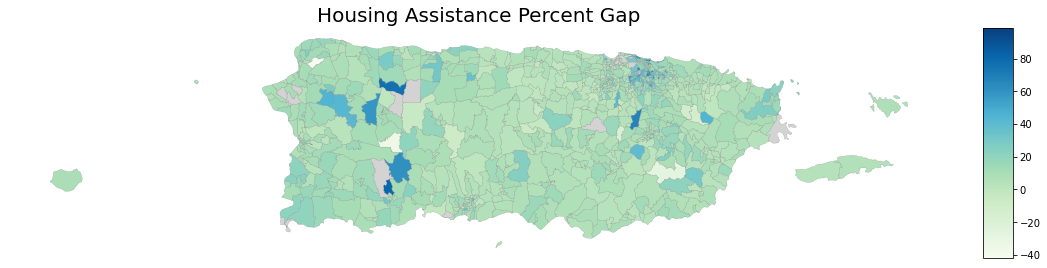

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Vislualize
fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

census_tract_percent_gap_map.plot(column='percent_gap', edgecolor='grey', linewidth=.2, 
                                    ax=ax, legend=True, cax=cax, cmap='GnBu', missing_kwds={'color': 'lightgrey'})

# title and layout
ax.set_title('Housing Assistance Percent Gap', fontsize=20)
ax.axis('off')
plt.tight_layout()